<a href="https://colab.research.google.com/github/Ramubala/face-recognition/blob/main/FaceVerification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#!rm -rf '/content/data' 
# !rm -rf '/content/annotations'

In [3]:
# !mkdir data
# !mkdir annotations
# !tar zxvf '/content/drive/MyDrive/datasets/originalPics.tar.gz' -C '/content/data/' ;
# !tar zxvf '/content/drive/MyDrive/datasets/FDDB-folds.tgz' -C '/content/annotations/';

In [4]:
# import glob
# file_list = [file for file in glob.glob(r'/content/annotations/FDDB-folds/*-ellipseList.txt',recursive=True)]
# train_files, test_files = file_list[:9],[file_list[9]]
# print(train_files, test_files)

In [5]:
#custom_train_dataset[2]

In [6]:
# def per_person_stats(source_txt: str):
#   stats_dict=dict()
#   with open(source_txt,'r') as f:
#     data = f.readlines()
#     for i in range(1, len(data)):
#       line = data[i].strip().split("\t")
#       stats_dict[line[0]] = int(line[1])
#   f.close()
#   return stats_dict

In [7]:
# def pick_train_pairs(_dict, num_per_sample, num_negative_faces_per_sample):
#   if num_per_sample!=3:
#     raise Exception("only 3 per sample supported by algorithm")
#   allfaces = list(_dict.keys())
#   data = []
#   for key in allfaces:
#     # anchor and postive example
#     facepath = '/content/data/lfw-py/lfw_funneled/{}'.format(key)
#     available_images = [file for file in glob.glob(facepath+'/*.jpg')]
#     num_available_images = _dict[key]
#     num_achor_postive_pairs = num_available_images*(num_available_images-1)
#     if num_achor_postive_pairs==0:
#       combinations = [(available_images[0],available_images[0])]
#     else:
#       combinations = list(itertools.combinations(available_images, 2))

#     # negative face
#     possible_choices = [v for v in allfaces if v != key]
#     negative_examples = random.sample(possible_choices, num_negative_faces_per_sample)
#     for negative_example in negative_examples:
#       negfacepath = '/content/data/lfw-py/lfw_funneled/{}'.format(negative_example)
#       available_images = [file for file in glob.glob(negfacepath+'/*.jpg')]
#       neg_imgpath = random.choice(available_images)

#       for tuple_el in combinations:
#         data.append((tuple_el[0],tuple_el[1],neg_imgpath))
#   return data  

In [8]:
# train_txt_file = '/content/data/lfw-py/peopleDevTrain.txt'
# test_txt_file = '/content/data/lfw-py/peopleDevTest.txt'
# train_stats = per_person_stats(train_txt_file)
# test_stats = per_person_stats(test_txt_file)

In [9]:
#test_stats.keys() & train_stats.keys()

In [10]:
# train_data = pick_train_pairs(train_stats, 3, 5)

In [11]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install cudnn=8.3.2

# VERSION = "20200318" #@param ["20200318","nightly", "xrt==1.15.0"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [12]:
import torchvision
import torch
import os
import glob
import numpy as np
import itertools
import random
import imutils
random.seed(42)
from torch.utils.data import DataLoader,Dataset,Sampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# import torch_xla
# import torch_xla.core.xla_model as xm

In [13]:
# transformation = transforms.Compose([
#                                  transforms.ToTensor(),
#                                  #transforms.Normalize((mean,), (std,))
#                              ])

# train_dataset = torchvision.datasets.LFWPeople('/content/data/',split='train',download=True,transform=transformation)
# test_dataset = torchvision.datasets.LFWPeople('/content/data/',split='test',download=True,transform=transformation)

#train_dataset = torchvision.datasets.MNIST('/content/data/',train=True,download=True)
#test_dataset = torchvision.datasets.MNIST('/content/data/',train=False,download=True)
#mean, std = 0.28604059698879553, 0.35302424451492237

# train_dataset = torchvision.datasets.FashionMNIST('./content/data/FashionMNIST', train=True, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((mean,), (std,))
#                              ]))
# test_dataset = torchvision.datasets.FashionMNIST('/content/data/FashionMNIST', train=False, download=True,
#                             transform=transforms.Compose([
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((mean,), (std,))
#                             ]))

In [14]:
transformation = transforms.Compose([
                                 transforms.ToTensor()
                             ])

train_dataset = torchvision.datasets.LFWPeople('/content/data/',split='train',download=True,transform=transformation)
test_dataset = torchvision.datasets.LFWPeople('/content/data/',split='test',download=True,transform=transformation)

  0%|          | 0/243346528 [00:00<?, ?it/s]

Extracting /content/data/lfw-py/lfw-funneled.tgz to /content/data/lfw-py


  0%|          | 0/66403 [00:00<?, ?it/s]

  0%|          | 0/94727 [00:00<?, ?it/s]

Using downloaded and verified file: /content/data/lfw-py/lfw-funneled.tgz
Extracting /content/data/lfw-py/lfw-funneled.tgz to /content/data/lfw-py


  0%|          | 0/28334 [00:00<?, ?it/s]

Using downloaded and verified file: /content/data/lfw-py/lfw-names.txt


In [15]:
len(train_dataset)+len(test_dataset)

13233

In [16]:
images, labels = next(iter(DataLoader(train_dataset, 32, shuffle=False)))
grid_img = torchvision.utils.make_grid(images, nrow=5)

In [17]:
# find mean and std
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64)

def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std
  
mean, std = get_mean_and_std(train_dataloader)

In [18]:
transformation = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(tuple(mean.numpy()),tuple(std.numpy()))
                             ])

train_dataset = torchvision.datasets.LFWPeople('/content/data/',split='train',download=False,transform=transformation)
test_dataset = torchvision.datasets.LFWPeople('/content/data/',split='test',download=False,transform=transformation)

In [19]:
train_dataset[0][0].shape

torch.Size([3, 250, 250])

In [20]:
images, labels = next(iter(DataLoader(train_dataset, 32, shuffle=False)))
grid_img_after_transform = torchvision.utils.make_grid(images, nrow=5)

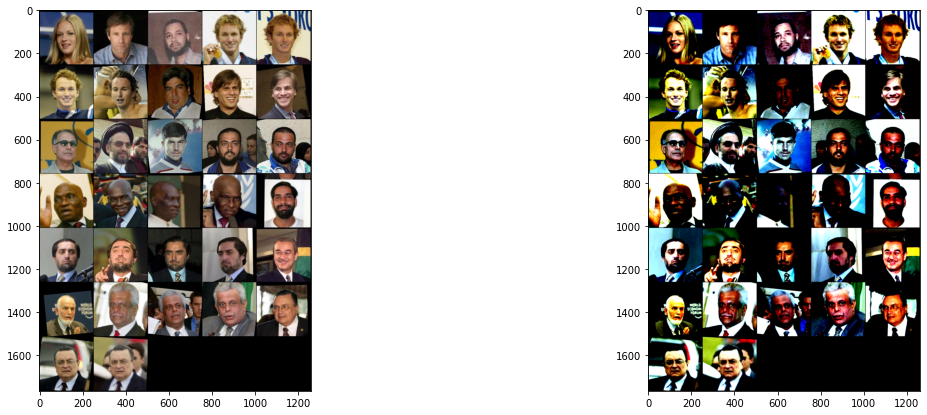

In [21]:
fig,ax=plt.subplots(1,2,figsize=(20,7))
ax[0].imshow(grid_img.permute(1, 2, 0))
ax[1].imshow(grid_img_after_transform.permute(1, 2, 0))

In [22]:
from torch.utils.data.dataloader import BatchSampler
import gc

# This constructs a new dataset from src dataset with anchor-positive-negative triplet
# The length of samples from this loader would be upsampling_factor*len(src_dataset)
class CustomDataset(Dataset):
  def __init__(self, src_dataset, upsampling_factor=5):

    # input source dataset

    self.src_dataset = src_dataset 

    # get all source labels in train
    self.src_labels = np.array([src_dataset[i][1] for i in range(len(src_dataset))]) 
    self.labels = list(set(self.src_labels))
    self.label_to_index= {label: np.where(self.src_labels == label)[0]
                                     for label in self.labels}
    self.upsampling_factor = upsampling_factor

  def __len__(self):
      return self.upsampling_factor*len(self.src_dataset)

  def __getitem__(self, idx : int):
      # anchor image
      ref_dataset_index = int(idx/self.upsampling_factor)
      ref_train_image = self.src_dataset[ref_dataset_index]
      label = ref_train_image[1]

      # finding positive example
      possible_positive_choices = self.label_to_index[label]
      possible_positive_choices = [v for v in possible_positive_choices] #if v!= idx]
      choice = random.choice(possible_positive_choices)
      positive_train_image = self.src_dataset[choice]

      # finding negative example
      possible_neg_choices = [v for v in self.labels if v!= label]
      choice = random.choice(possible_neg_choices)
      choose_neg_idx = random.choice(self.label_to_index[choice])
      negative_train_image = self.src_dataset[choose_neg_idx]

      return (ref_train_image[0], positive_train_image[0], negative_train_image[0]), (ref_train_image[1], positive_train_image[1], negative_train_image[1])


_train_dataset = CustomDataset(train_dataset, 1)
_test_dataset = CustomDataset(test_dataset, 1)

In [23]:
len(_train_dataset), len(_test_dataset)

(9525, 3708)

In [24]:
# torch.save(_train_dataset, 'train.pt')
# torch.save(_test_dataset,'test.pt')

In [25]:
class BatchSamplerUniform(Sampler):
  def __init__(self, labels, n_classes, n_samples):
    self.labels = labels
    self.batch_size = n_classes*n_samples
    self.unique_labels = list(set(labels))
    self.n_classes = n_classes
    self.n_samples = n_samples
    self.labels_to_index_map = {label: np.where(self.labels == label)[0]
                                      for label in self.unique_labels}
    self.used_up_samples = {label: 0 for label in self.unique_labels}
    self.count=0

  def __iter__(self):
    while self.count + self.batch_size < len(self.labels):
      sampled_classes = np.random.choice(self.unique_labels, self.n_classes, replace=False)
      indices = []
      for label in sampled_classes:
        available_indices = self.labels_to_index_map[label]
        last_index_used = self.used_up_samples[label]
        samples = available_indices[last_index_used:last_index_used+self.n_samples]
        self.used_up_samples[label] = last_index_used+self.n_samples
        if self.used_up_samples[label]+self.n_samples>len(available_indices):
          np.random.shuffle(self.labels_to_index_map[label])
          self.used_up_samples[label]=0
        indices.extend(samples)
      self.count+=self.batch_size
      yield indices

  def __len__(self):
    return len(self.labels)//self.batch_size

In [26]:
kwargs = {'num_workers': 1, 'pin_memory': True}
train_dataloader = DataLoader(_train_dataset, batch_sampler=BatchSamplerUniform(_train_dataset.src_labels, 10, 25), **kwargs)
test_dataloader = DataLoader(_test_dataset, batch_size=128, shuffle=False)#, **kwargs)

## Define models

In [27]:
import torch
import torch.nn as nn
from torch.nn.modules.pooling import MaxPool2d

In [28]:
class BasicConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride ):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride),
        nn.BatchNorm2d(num_features=out_channels)
    )
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.relu(self.model(x))

In [38]:
class FaceSimilarity(nn.Module):
  def __init__(self):
    super().__init__()
    # self.conv_layers = nn.Sequential(
    #         nn.Conv2d(1, 64, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.Conv2d(64, 128, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.Conv2d(128, 256, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.Conv2d(256, 256, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.Conv2d(256, 512, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.Conv2d(512, 512, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.Conv2d(512, 512, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.Conv2d(512, 512, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2, stride=2)
    #     )
    self.conv_layers = nn.Sequential(nn.Conv2d(3, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(64, 64, 3), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),)

    self.fc_layers = nn.Sequential(nn.Linear(16*56*56, 256),
                        nn.PReLU(),
                        nn.Linear(256, 256),
                        nn.PReLU(),
                        nn.Linear(256,2)
                        )
    # self.conv_layers = nn.Sequential(
    #     BasicConv2d(in_channels=3,out_channels=64,kernel_size=5,stride=2),
    #     nn.MaxPool2d(kernel_size=3,stride=2),
    #     #BasicConv2d(in_channels=64,out_channels=64,kernel_size=1,stride=1),
    #     BasicConv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1),
    #     nn.MaxPool2d(kernel_size=3,stride=2),
    #     #BasicConv2d(in_channels=192,out_channels=192,kernel_size=1,stride=1),
    #     BasicConv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1),
    #     nn.MaxPool2d(kernel_size=3,stride=2),
    #     #BasicConv2d(in_channels=384,out_channels=384,kernel_size=1,stride=1),
    #     BasicConv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1),
    #     BasicConv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1),
    #     BasicConv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1),
    #     BasicConv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1),
    #     BasicConv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1),
    #     nn.MaxPool2d(kernel_size=3,stride=2),
    # )

    # self.fc_layers = nn.Sequential(
    #     nn.Linear(in_features=2*2*256,out_features=128),
    #     nn.Linear(in_features=128, out_features=2),
    #     #nn.Linear(in_features=32*128, out_features=1*128)
    # )

  def forward(self,x):
    x = x.cuda()
    conv_output = self.conv_layers(x)
    conv_output = conv_output.view(conv_output.shape[0],-1)
    linear_layers_output  = self.fc_layers(conv_output)
    #l2_norm_output  =(linear_layers_output/(linear_layers_output.pow(2).sum(1, keepdim=True).sqrt())).squeeze(0)
    return linear_layers_output.squeeze(0)


In [39]:
class TripletModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.face_similarity = FaceSimilarity()
    
    def forward(self, anchor, positive, negative):
      rep_1 = self.face_similarity(anchor)
      rep_2 = self.face_similarity(positive)
      rep_3 = self.face_similarity(negative)
      return rep_1, rep_2, rep_3

    def get_embedding(self,x):
      return self.face_similarity.forward(x)

Define metrics

In [40]:
class TripletLoss(nn.Module):
  def __init__(self, alpha):
    super().__init__()
    self.margin = alpha

  def forward(self, embeddings, target_labels):
    distance_positive = (embeddings[:,0] - embeddings[:,1]).pow(2).sum(1)
    distance_negative = (embeddings[:,0] - embeddings[:,2]).pow(2).sum(1)
    loss = torch.nn.functional.relu(distance_positive - distance_negative + self.margin)
    accuracy = 100*(1-torch.count_nonzero(loss)/len(loss))
    return loss.mean(), accuracy

In [41]:
from itertools import combinations

class OnlineTripletLoss(nn.Module):
  def __init__(self, alpha):
    super().__init__()
    self.margin = alpha

  def pdist(self, vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    #distance_matrix = np.linalg.norm(vectors-b)
    return distance_matrix

  def hardest_negative(self, loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

  def random_hard_negative(self, loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None

  def get_pairs_with_hard_negative(self, embeddings, target_labels):
    distance_matrix = self.pdist(embeddings)
    distance_matrix = distance_matrix.cpu()
    labels = target_labels.cpu().data.numpy()
    triplets = []

    for label in set(labels.flatten()):
        label_mask = (labels == label)
        label_indices = np.where(label_mask)[0]
        if len(label_indices) < 2:
            continue
        negative_indices = np.where(np.logical_not(label_mask))[0]
        anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
        anchor_positives = np.array(anchor_positives)

        ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
        for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
            loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
            loss_values = loss_values.data.cpu().numpy()
            hard_negative = self.random_hard_negative(loss_values)
            if hard_negative is not None:
                hard_negative = negative_indices[hard_negative]
                triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

    if len(triplets) == 0:
        triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

    triplets = np.array(triplets)

    return torch.LongTensor(triplets)

  def forward(self, embeddings, target_labels):
    embeddings = torch.cat(embeddings,dim=1)
    for sub_list in target_labels:
      target_labels = torch.stack(sub_list,dim=0).T
    triplets = self.get_pairs_with_hard_negative(embeddings, target_labels)
    if embeddings.is_cuda:
             triplets = triplets.cuda()
    ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)  # .pow(.5)
    an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)  # .pow(.5)
    loss = torch.nn.functional.relu(ap_distances - an_distances + self.margin)
    accuracy = 100*torch.count_nonzero(loss)/len(loss)

    return loss.mean(), accuracy

In [42]:
def train_model(dataloader,model,optimizer,criterion):
  model.train()
  train_loss=0
  classification_accuracy=0
  for i, (input, target) in enumerate(dataloader):
    optimizer.zero_grad()
    output = model(*input)#.cuda()
    if type(output) not in (tuple, tuple):
       output = (output,)
    loss_inputs = output
    if target is not None:
       target = (target,)
       loss_inputs += target
    loss, accuracy = criterion(output,target)
    classification_accuracy+=accuracy
    loss.backward()
    train_loss+=loss
    optimizer.step()
  return train_loss/len(dataloader)#, classification_accuracy/len(dataloader)

In [43]:
def eval_model(dataloader,model,optimizer,criterion):
  model.eval()
  val_loss=0
  classification_accuracy=0
  with torch.no_grad():
    for i, (input, target) in enumerate(dataloader):
      output = model(*input)#.cuda()
      if type(output) not in (tuple, tuple):
        output = (output,)
      loss_inputs = output
      if target is not None:
       target = (target,)
       loss_inputs += target
      loss, accuracy = criterion(output,target)
      classification_accuracy+=accuracy
      val_loss+=loss
    return val_loss/len(dataloader)#, classification_accuracy/len(dataloader)

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [45]:
def fit(max_epochs, model, optimizer, criterion):
  min_val_loss = float('inf')

  for i in range(max_epochs):
    start_time = time.time()

    # train model
    train_loss = train_model(train_dataloader, model, optimizer, criterion)
    
    # val model loss
    val_loss = eval_model(test_dataloader, model, optimizer, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {i:02} | Time: {epoch_mins}m {epoch_secs}s')
    print("Epoch {} elapsed, train_loss: {}, val_loss: {}".format(i,train_loss,val_loss))
    if val_loss<min_val_loss:
      min_val_loss = val_loss
      torch.save(model, '/content/face_verification.pt')

In [46]:
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = OnlineTripletLoss(alpha=1)
model = TripletModel().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-4)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
fit(40, model, optimizer, criterion)

13002247
Epoch: 00 | Time: 1m 1s
Epoch 0 elapsed, train_loss: 1.3330085277557373, val_loss: 1.7717443704605103
Epoch: 01 | Time: 0m 51s
Epoch 1 elapsed, train_loss: 0.0, val_loss: 1.8173178434371948
Epoch: 02 | Time: 0m 51s
Epoch 2 elapsed, train_loss: 0.0, val_loss: 1.7370076179504395
Epoch: 03 | Time: 0m 51s
Epoch 3 elapsed, train_loss: 0.0, val_loss: 1.801520586013794
Epoch: 04 | Time: 0m 51s
Epoch 4 elapsed, train_loss: 0.0, val_loss: 1.736284613609314
Epoch: 05 | Time: 0m 50s
Epoch 5 elapsed, train_loss: 0.0, val_loss: 1.78048837184906
Epoch: 06 | Time: 0m 49s
Epoch 6 elapsed, train_loss: 0.0, val_loss: 1.8037426471710205
Epoch: 07 | Time: 0m 51s
Epoch 7 elapsed, train_loss: 0.0, val_loss: 1.762417197227478


KeyboardInterrupt: ignored

In [47]:
saved_model = torch.load('/content/face_verification.pt')

In [48]:
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(100):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for i, (images, target) in enumerate(dataloader):
            #if device=='cuda':
            #    images = images.cuda()
            embeddings[k:k+len(images[0])] = model.get_embedding(images[0]).data.cpu().numpy()
            labels[k:k+len(images[0])] = target[0].numpy()
            k += len(images[0])
    return embeddings, labels

In [49]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_dataloader, model)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_dataloader, model)

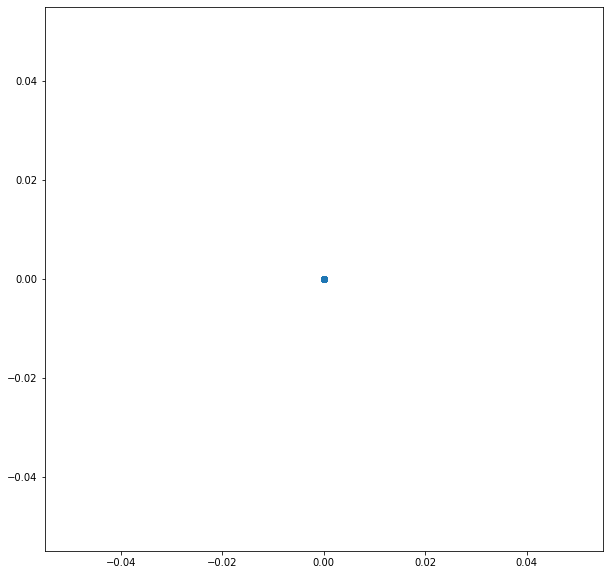

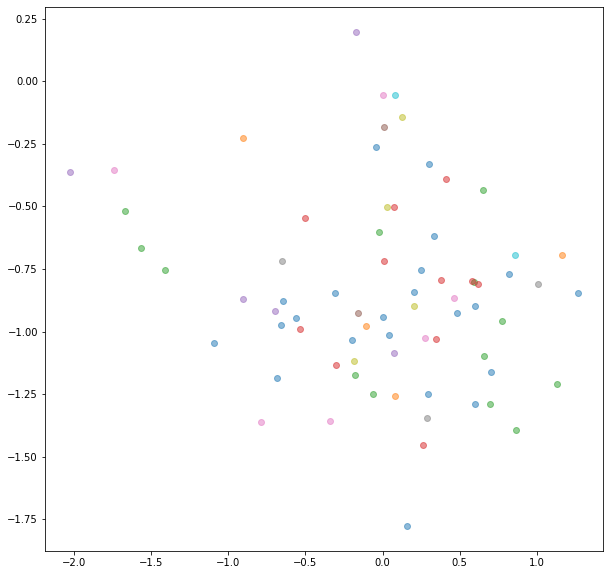

In [50]:
plot_embeddings(train_embeddings_otl, train_labels_otl)
plot_embeddings(val_embeddings_otl, val_labels_otl)